In [2]:
from math import sqrt
from scipy import stats
from pydataset import data
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import sklearn.metrics

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from env import host, user, password, sql_connect
from wrangle import wrangle_telco, wrangle_zillow, split_data

## Exercise: Exploration

#### Our Telco scenario continues:

    - As a customer analyst for Telco, you want to know who has spent the most money with the company over their lifetime. You have monthly charges and tenure, so you think you will be able to use those two attributes as features to estimate total charges. You need to do this within an average of $5.00 per customer

#### In these exercises, you will run through the stages of exploration as you continue to work toward the above goal.

#### Question 1: Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.



In [3]:
telco_df = wrangle_telco()
telco_df.head()

,customer_id,monthly_charges,tenure,total_charges
0,0013-SMEOE,109.70,71,7904.25
1,0014-BMAQU,84.65,63,5377.80
2,0016-QLJIS,90.45,65,5957.90
3,0017-DINOC,45.20,54,2460.55
4,0017-IUDMW,116.80,72,8456.75


In [4]:
train, validate, test = split_data(telco_df)
train.shape, validate.shape, test.shape

((949, 4), (407, 4), (339, 4))

<AxesSubplot:xlabel='tenure', ylabel='total_charges'>

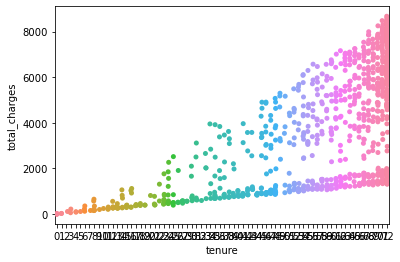

In [5]:
sns.stripplot(data = train, x = 'tenure', y = 'total_charges')

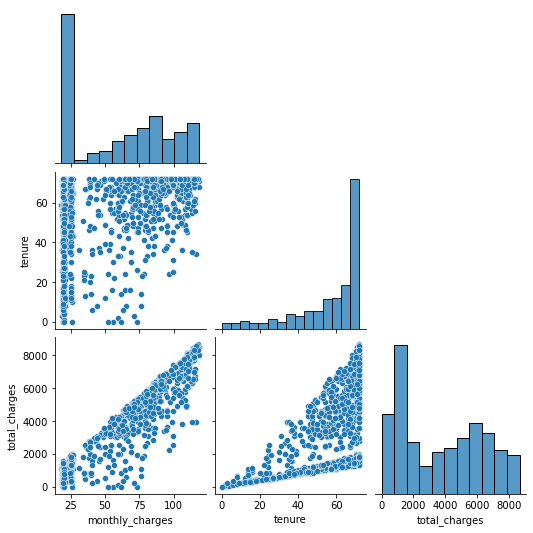

In [6]:
sns.pairplot(train, corner = True)

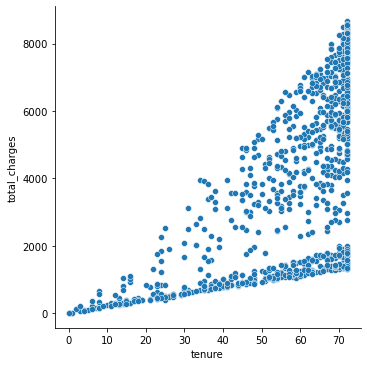

In [7]:
sns.relplot(data = train, x = 'tenure', y = 'total_charges')

<AxesSubplot:>

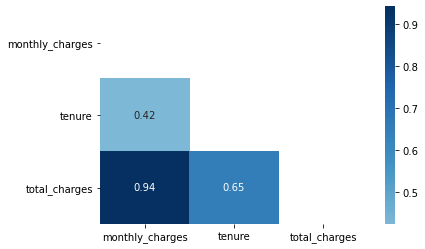

In [8]:
sns.heatmap(train.corr(), cmap ='RdBu', center = 0, annot = True, mask = np.triu(train.corr()))

#### Question 2: Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.



In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949 entries, 1256 to 1593
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      949 non-null    object 
 1   monthly_charges  949 non-null    float64
 2   tenure           949 non-null    int64  
 3   total_charges    949 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 77.1+ KB


In [10]:
def plot_variable_pairs(df):
    sns.pairplot(df, corner = True, kind = 'reg', plot_kws={'line_kws':{'color':'red'}})

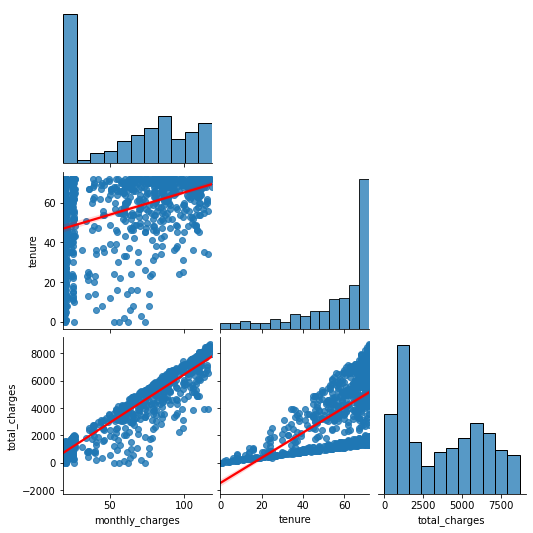

In [11]:
plot_variable_pairs(train)

#### Question 3: Write a function named months_to_years that accepts your telco churn dataframe and returns a dataframe with a new feature tenure_years, in complete years as a customer.



In [12]:
telco_df.head()

,customer_id,monthly_charges,tenure,total_charges
0,0013-SMEOE,109.70,71,7904.25
1,0014-BMAQU,84.65,63,5377.80
2,0016-QLJIS,90.45,65,5957.90
3,0017-DINOC,45.20,54,2460.55
4,0017-IUDMW,116.80,72,8456.75


In [13]:
telco_df.tenure / 12

0       5.916667
1       5.250000
2       5.416667
3       4.500000
4       6.000000
          ...   
1690    5.916667
1691    5.583333
1692    3.833333
1693    5.583333
1694    5.250000
Name: tenure, Length: 1695, dtype: float64

In [14]:
telco_df['tenure_years'] = (telco_df.tenure / 12).astype(int)
telco_df.head()

,customer_id,monthly_charges,tenure,total_charges,tenure_years
0,0013-SMEOE,109.70,71,7904.25,5
1,0014-BMAQU,84.65,63,5377.80,5
2,0016-QLJIS,90.45,65,5957.90,5
3,0017-DINOC,45.20,54,2460.55,4
4,0017-IUDMW,116.80,72,8456.75,6


In [15]:
telco_df = telco_df.drop(columns = 'tenure_years')
telco_df.head()

,customer_id,monthly_charges,tenure,total_charges
0,0013-SMEOE,109.70,71,7904.25
1,0014-BMAQU,84.65,63,5377.80
2,0016-QLJIS,90.45,65,5957.90
3,0017-DINOC,45.20,54,2460.55
4,0017-IUDMW,116.80,72,8456.75


In [16]:
def months_to_years(df):
    '''
    This function creates a total completed years column for the customers in the telco 
    dataframe by taking the current tenure in months dividing it by 12 and returning it 
    as an integer
    '''
    df['tenure_years'] = (df.tenure / 12).astype(int)
    return df

In [17]:
months_to_years(telco_df)

,customer_id,monthly_charges,tenure,total_charges,tenure_years
0,0013-SMEOE,109.70,71,7904.25,5
1,0014-BMAQU,84.65,63,5377.80,5
2,0016-QLJIS,90.45,65,5957.90,5
3,0017-DINOC,45.20,54,2460.55,4
4,0017-IUDMW,116.80,72,8456.75,6
...,...,...,...,...,...
1690,9964-WBQDJ,24.40,71,1725.40,5
1691,9972-EWRJS,19.25,67,1372.90,5
1692,9975-GPKZU,19.75,46,856.50,3
1693,9993-LHIEB,67.85,67,4627.65,5


#### Question 4: Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.



In [18]:
telco_df.head()

,customer_id,monthly_charges,tenure,total_charges,tenure_years
0,0013-SMEOE,109.70,71,7904.25,5
1,0014-BMAQU,84.65,63,5377.80,5
2,0016-QLJIS,90.45,65,5957.90,5
3,0017-DINOC,45.20,54,2460.55,4
4,0017-IUDMW,116.80,72,8456.75,6


In [19]:
train, validate, test = split_data(telco_df)
train.shape, validate.shape, test.shape

((949, 5), (407, 5), (339, 5))

In [37]:
def plot_categorical_and_continuous_vars(df, cols, cats):
    for col in df[cols]:
        sns.relplot(data = df, x = df[col], y = cats, kind = 'scatter')
        plt.show()

    for col in df[cols]:
        sns.jointplot(data = df, x =df[col], y = cats, kind = 'scatter')
        plt.show()
        
    sns.heatmap(df.corr(), cmap ='RdBu', center = 0, annot = True, annot_kws={"size": 15})
    plt.show()
    

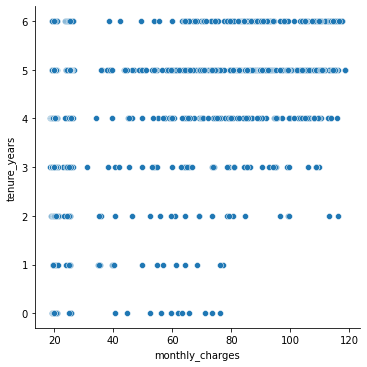

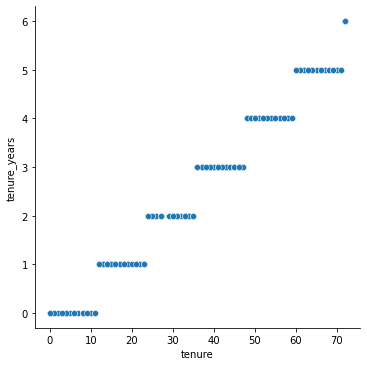

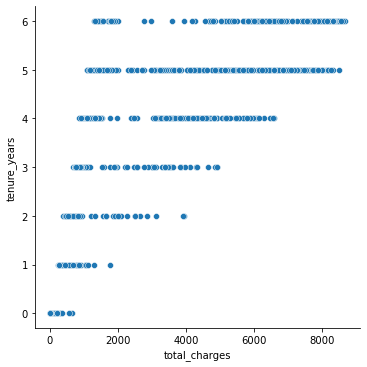

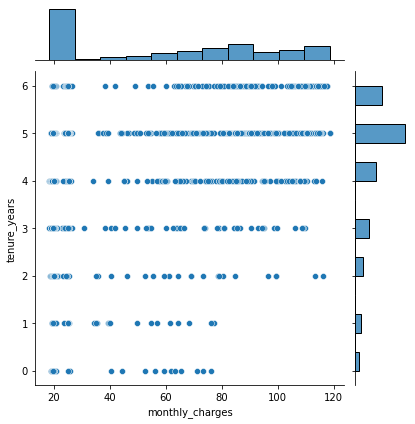

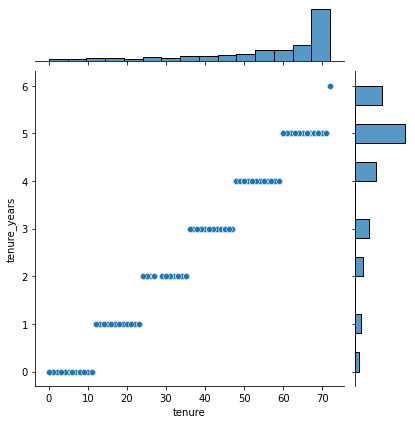

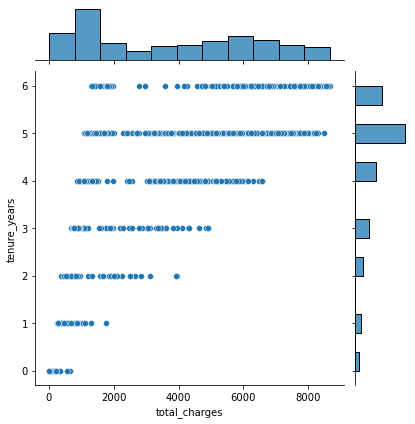

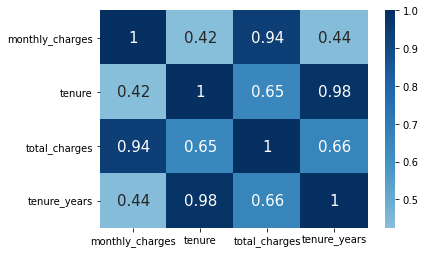

In [38]:
cols = ['monthly_charges', 'tenure', 'total_charges']
plot_categorical_and_continuous_vars(train, cols, train.tenure_years)